In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST, EMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from BayesLeNet5 import BayesLeNet5
from utils import confidence_score

In [2]:
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 1.5
fig_scale = 6

## Data generation

In [3]:
classesEMNIST = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", 
                  "A", "B", "C", 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
                  'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
                  'U', 'V', 'W', 'X', 'Y', 'Z', "a", "b", "c", 'd', 
                  'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
                  'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
                  'y', 'z']

def transpose(image):
    image = image[0].t().reshape(1, image.size()[1], image.size()[1])
    return image

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(), 
    transpose
])
batch_size = 1024
EMNIST_dataset = EMNIST(
    root="data/", 
    download=True, 
    train=False, 
    split='byclass', 
    transform=transform
)
EMNIST_loader = DataLoader(
    dataset=EMNIST_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BayesLeNet5()
model.to(device)
checkpoint = torch.load('models/bayeslenet5.pt')
model.load_state_dict(checkpoint['state_dict'])

n_samples = 100
output_samples = np.empty((n_samples, len(EMNIST_dataset), 10))
with torch.no_grad():
    for i, (input, _) in enumerate(EMNIST_loader):
        input = input.to(device)
        for j in range(n_samples):
            start = i * batch_size
            end = start + input.size()[0]
            output_samples[j, start:end, :] = F.softmax(model(input), dim=1).cpu().numpy()

outputs = output_samples.mean(axis=0)
confidence = confidence_score(output_samples)
labels = np.argmax(outputs, axis=1)

## Figure 2a

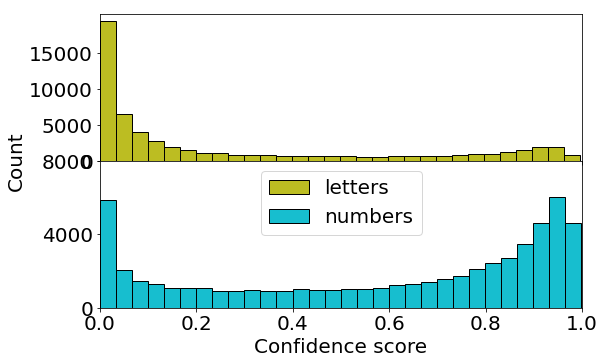

In [4]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(1.6*fig_scale*0.9, 1*fig_scale*0.9), 
    sharex=True
)

mask = np.array(
    list(map(
        lambda x: x not in range(10), 
        EMNIST_dataset.targets.numpy()
    ))
)

ax[0].hist(
    confidence[mask], 
    bins=30, 
    color='tab:olive', 
    edgecolor='black'
)
ax[1].hist(
    [], 
    bins=30, 
    color='tab:olive', 
    label='letters', 
    edgecolor='black'
)
ax[1].hist(
    confidence[~mask], 
    bins=30, 
    color='tab:cyan', 
    label='numbers', 
    edgecolor='black'
)

ax[0].set_yticks(np.linspace(0, 15000, 4))
ax[1].set_yticks(np.linspace(0, 8000, 3))
ax[1].set_xlim(0, 1)
ax[1].legend(prop={'size': 20})

fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor='none', 
    top=False, 
    bottom=False, 
    left=False, 
    right=False
)
plt.xlabel("Confidence score")
plt.ylabel("Count", labelpad=35)

plt.subplots_adjust(hspace=0)
#plt.savefig('figure2a.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

## Figure 2b

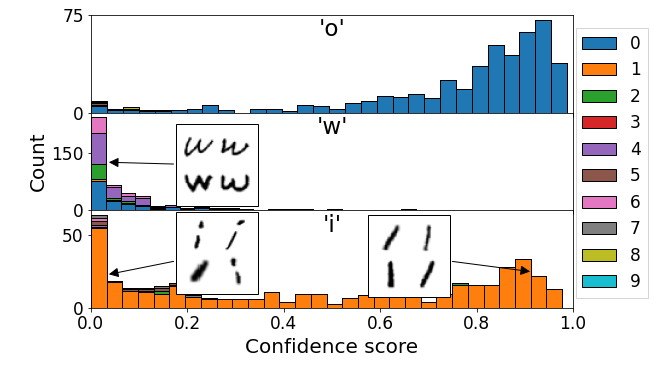

In [5]:
fig, ax = plt.subplots(
    3, 1, 
    figsize=(1.6*fig_scale*0.9, 1*fig_scale*0.9), 
    sharex=True
)

colors = [plt.get_cmap('tab10')(i/10) for i in range(10)]
targets = EMNIST_dataset.targets.numpy()
images = EMNIST_dataset.data.numpy()

mask = targets == classesEMNIST.index('o')
values = [confidence[mask][labels[mask]==n] for n in range(10)]
ax[0].hist(
    values, 
    bins=30, 
    color=colors, 
    edgecolor='black', 
    stacked=True, 
    label=range(10)
)
ax[0].text(
    0.5, .78, 
    "'o'", 
    size=23,
    horizontalalignment='center',
    transform=ax[0].transAxes
)
ax[0].tick_params(
    axis='both', 
    which='major', 
    labelsize=17
)
ax[0].set_yticks(np.linspace(0, 75, 2))

mask = np.logical_and(
    targets == classesEMNIST.index('o'), 
    confidence > 0.93
)
size = images.shape[2]
img = np.zeros((2*size+2, 2*size+2))
img[:size,:size] = images[mask][0]
img[size+2:,:size] = images[mask][1]
img[:size,size+2:] = images[mask][2]
img[size+2:,size+2:] = images[mask][3]

im = OffsetImage(255-img.T, zoom=1.2, cmap='gray')
im.image.axes = ax[0]
ab = AnnotationBbox(
    im, [0.93, 85],
    xybox=(-123, -27),
    xycoords='data',
    boxcoords="offset points",
    pad=0.3,
    arrowprops=dict(arrowstyle="-|>", 
                    color='black')
)
ax[0].add_artist(ab)

mask = targets == classesEMNIST.index('w')
values = [confidence[mask][labels[mask]==n] for n in range(10)]
ax[1].hist(
    values, 
    bins=30, 
    color=colors, 
    edgecolor='black', 
    stacked=True
)
ax[1].text(
    0.5, .78, 
    "'w'", 
    size=23,
    horizontalalignment='center',
    transform=ax[1].transAxes
)
ax[1].tick_params(
    axis='both', 
    which='major', 
    labelsize=17
)
ax[1].set_yticks(np.linspace(0, 150, 2))

mask = np.logical_and(
    targets == classesEMNIST.index('w'), 
    confidence < 0.03
)
mask = np.logical_and(mask, labels == 4)
size = images.shape[2]
img = np.zeros((2*size+2, 2*size+2))
img[:size,:size] = images[mask][0]
img[size+2:,:size] = images[mask][1]
img[:size,size+2:] = images[mask][2]
img[size+2:,size+2:] = images[mask][3]

im = OffsetImage(255-img.T, zoom=1.2, cmap='gray')
im.image.axes = ax[1]
ab = AnnotationBbox(
    im, [0.033, 125],
    xybox=(110, -3),
    xycoords='data',
    boxcoords="offset points",
    pad=0.3,
    arrowprops=dict(arrowstyle="-|>", 
                    color='black')
)
ax[1].add_artist(ab)

mask = targets == classesEMNIST.index('i')
values = [confidence[mask][labels[mask]==n] for n in range(10)]
ax[2].hist(
    values, 
    bins=30, 
    color=colors, 
    edgecolor='black', 
    stacked=True
)
ax[2].text(
    0.5, 0.78, 
    "'i'", 
    size=23,
    horizontalalignment='center',
    transform=ax[2].transAxes
)
ax[2].tick_params(
    axis='both', 
    which='major', 
    labelsize=17
)

mask = np.logical_and(
    targets == classesEMNIST.index('i'), 
    confidence < 0.03
)
mask = np.logical_and(mask, labels == 1)
size = images.shape[2]
img = np.zeros((2*size+2, 2*size+2))
img[:size,:size] = images[mask][0]
img[size+2:,:size] = images[mask][1]
img[:size,size+2:] = images[mask][2]
img[size+2:,size+2:] = images[mask][3]

im = OffsetImage(255-img.T, zoom=1.2, cmap='gray')
im.image.axes = ax[2]
ab = AnnotationBbox(
    im, [0.033, 23],
    xybox=(110, 22),
    xycoords='data',
    boxcoords="offset points",
    pad=0.3,
    arrowprops=dict(arrowstyle="-|>", 
                    color='black')
)
ax[2].add_artist(ab)

mask = np.logical_and(
    targets == classesEMNIST.index('i'), 
    confidence > 0.915
)
mask = np.logical_and(mask, labels == 1)
size = images.shape[2]
img = np.zeros((2*size+2, 2*size+2))
img[:size,:size] = images[mask][0]
img[size+2:,:size] = images[mask][1]
img[:size,size+2:] = images[mask][2]
img[size+2:,size+2:] = images[mask][3]

im = OffsetImage(255-img.T, zoom=1.2, cmap='gray')
im.image.axes = ax[2]
ab = AnnotationBbox(
    im, [0.915, 25],
    xybox=(-123, 16),
    xycoords='data',
    boxcoords="offset points",
    pad=0.3,
    arrowprops=dict(arrowstyle="-|>", 
                    color='black')
)
ax[2].add_artist(ab)

ax[2].set_xlim(0, 1)
ax[0].legend(
    loc='upper center', 
    bbox_to_anchor=(1.08, 0.95), 
    shadow=False, 
    ncol=1, 
    prop={'size': 17}, 
    fancybox=False
)

fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor='none', 
    top=False, 
    bottom=False, 
    left=False, 
    right=False
)
plt.xlabel("Confidence score")
plt.ylabel("Count")

plt.subplots_adjust(hspace=0)
#plt.savefig('figure2b.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()